In [9]:
from datetime import datetime

In [1]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import keras
from keras import layers,Model,Input
import itertools

2024-06-20 20:26:48.727727: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-20 20:26:48.728606: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-20 20:26:48.796123: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-20 20:26:49.072005: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-20 20:26:49.778740: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warnin

# load the dataset

In [2]:
def process_images(folder_path):
    # List all files in the folder
    files = os.listdir(folder_path)
    images=[]

    for image_file in files:
        image_path = os.path.join(folder_path, image_file)
        image = tf.io.read_file(image_path)
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.convert_image_dtype(image, dtype="float32")
        image = tf.image.resize(image, (224,224))
        image=  np.expand_dims(image, axis=0)
        images.append(image)
    return np.array(images)

def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  image=np.clip(image, 0.0, 1.0)

  plt.imshow(image)
  if title:
    plt.title(title)

In [3]:
content= process_images('content')
style = process_images('style')
data=[]
for i in content:
    for j in style:
        data.append([i,j])

data= np.array(data)

2024-06-20 20:26:50.960054: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error


# create the encoder and decoder

In [5]:
def get_encoder():
    vgg19 = keras.applications.VGG19(
        include_top=False,
        weights="imagenet",
        input_shape=(224,224, 3),
    )
    vgg19.trainable = False
    mini_vgg19 = keras.Model(vgg19.input, vgg19.get_layer("block4_conv1").output)

    # inputs = layers.Input([*IMAGE_SIZE, 3])
    # mini_vgg19_out = mini_vgg19(inputs)
    # return keras.Model(inputs, mini_vgg19_out, name="mini_vgg19")
    return mini_vgg19
encoder = get_encoder()

def get_decoder():
    decoder = keras.Sequential(
        [
            layers.InputLayer((28, 28, 512)),
            layers.Conv2D(filters=512, kernel_size= 3, strides= 1, padding= "same", activation= "relu"),
            layers.UpSampling2D(),
            layers.Conv2D(filters=256, kernel_size= 3, strides= 1, padding= "same", activation= "relu"),
            layers.Conv2D(filters=256, kernel_size= 3, strides= 1, padding= "same", activation= "relu"),
            layers.Conv2D(filters=256, kernel_size= 3, strides= 1, padding= "same", activation= "relu"),
            layers.Conv2D(filters=256, kernel_size= 3, strides= 1, padding= "same", activation= "relu"),
            layers.UpSampling2D(),
            layers.Conv2D(filters=256, kernel_size= 3, strides= 1, padding= "same", activation= "relu"),
            layers.Conv2D(filters=256, kernel_size= 3, strides= 1, padding= "same", activation= "relu"),
            layers.UpSampling2D(),
            layers.Conv2D(filters=256, kernel_size= 3, strides= 1, padding= "same", activation= "relu"),
            layers.Conv2D(
                filters=3,
                kernel_size=3,
                strides=1,
                padding="same",
                activation="relu",
            )
        ]
    )
    return decoder

decoder_2 = get_decoder()


def adin_layer(content_featute,style_feature):
    epsilon = 1e-8
    con_mean,con_var= np.mean(content_featute,axis=(1,2)),np.std(content_featute,axis=(1,2))
    sty_mean,sty_var= np.mean(style_feature,axis=(1,2)),np.std(style_feature,axis=(1,2))
    normalized_feature= (sty_var+epsilon)*(content_featute-con_mean)/(con_var+epsilon)+sty_mean
    return normalized_feature
 
class AdaIN(tf.keras.layers.Layer):
    def __init__(self, epsilon=1e-5, **kwargs):
        super(AdaIN, self).__init__(**kwargs)
        self.epsilon = epsilon

    def call(self, inputs):
        content, style = inputs
        content_mean, content_variance = tf.nn.moments(content, axes=[1], keepdims=True)
        style_mean, style_variance = tf.nn.moments(style, axes=[1], keepdims=True)
        normalized_content = (content - content_mean) / tf.sqrt(content_variance + self.epsilon)
        stylized_content = normalized_content * tf.sqrt(style_variance + self.epsilon) + style_mean
        return stylized_content

    def compute_output_shape(self, input_shape):
        return input_shape[0]

In [6]:
encoded_content= np.array([encoder(c) for c in content])
encoded_style= np.array([encoder(c) for c in style])

x = []
for i in encoded_content:
    for j in encoded_style:
        x.append(adin_layer(i,j))

x= np.array(x)

# creating an feature extractor

In [7]:
# Define content and style layers
content_layers = ['block1_conv1']
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']
# Function to create a model that outputs content and style features
def create_feature_extractor(layers):
    vgg = tf.keras.applications.VGG19( include_top=False,weights='imagenet')
    vgg.trainable = False
    
    outputs = [vgg.get_layer(name).output for name in layers]
    return tf.keras.Model(inputs=vgg.inputs, outputs=outputs)
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)
    


class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = create_feature_extractor(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}


feature_extractor = StyleContentModel(style_layers, content_layers)

In [8]:
def style_content_loss(o,c,s):
    con_target,sty_tar=feature_extractor(c)['content'],feature_extractor(s)['style']
    con_achieve,sty_achieve= feature_extractor(o)['content'],feature_extractor(o)['style']
    content_loss=tf.add_n([tf.reduce_mean((con_target[name]-con_achieve[name])**2) 
                             for name in con_achieve.keys()])
    style_dim= tf.cast([tf.reduce_prod(sty_achieve[i].shape) for i in sty_achieve.keys()], dtype=tf.float32)
    style_dim={style_name: value
                  for style_name, value
                  in zip(sty_achieve.keys(), style_dim)}
    style_loss = tf.add_n([tf.reduce_mean((sty_achieve[name]-sty_tar[name])**2/(2*style_dim[name])) 
                           for name in sty_achieve.keys()])
    total_loss= (content_loss+style_loss/5)
    return total_loss

# train the decoder,save the model,load the model and train again


In [10]:
decoder= tf.keras.models.load_model('decoder_final_day.keras')

In [ ]:
# Optimizer
opt = tf.keras.optimizers.Adadelta(learning_rate=0.01)

# Training Loop
num_epochs = 50
num_batches = 220

for epoch in range(num_epochs):
    loss=0
    for batch in range(num_batches):
        with tf.GradientTape() as tape:
            decoded_images = decoder(x[batch])  # Forward pass: compute the decoded images 
            loss += style_content_loss(decoded_images, data[batch][0], data[batch][1])  # Assuming data contains the target data
        gradients = tape.gradient(loss, decoder.trainable_variables)
        clipped_gradients, _ = tf.clip_by_global_norm(gradients, 10)  # clip_norm is a hyperparameter
        # Apply gradients to update the model's parameters
        opt.apply_gradients(zip(clipped_gradients, decoder.trainable_variables))
    
    
        
        # Print the loss
    print(f'Epoch {epoch + 1}, Batch {batch + 1}, Loss: {loss.numpy()},Time: {datetime.now().strftime("%H:%M:%S")}')
    if epoch%5==0:
        decoder.save('decoder_final_day.keras')

print('Training complete')

In [ ]:
decoder.save('decoder_final_day.keras')

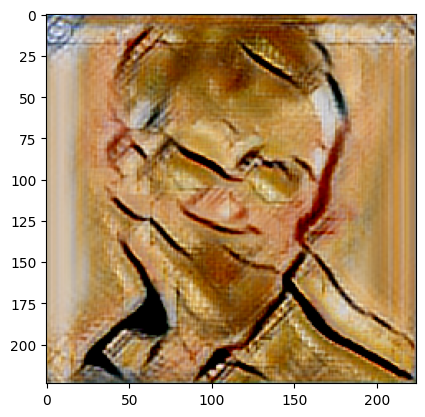

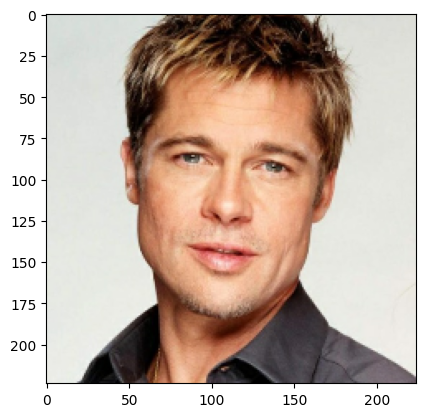

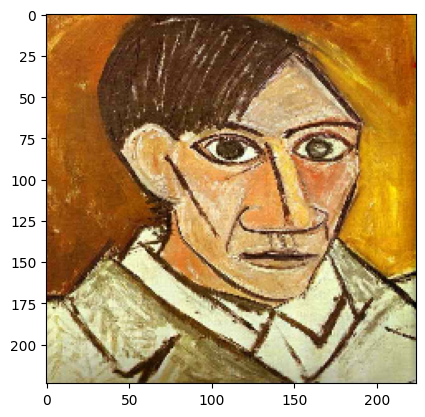

In [16]:
u=153
imshow(decoder(x[u]))
plt.show()
imshow(data[u][0])
plt.show()
imshow(data[u][1])